# Custom Yolo Object Detector

This notebook shows how to build a model to detect object using Yolov5 model.

## Virtual environnement 
Creation virtual environnement and install package to use jupyter notebook:
```console
python -m venv env
source ./env/bin/activate
python -m pip install --upgrade pip
pip install ipykernel
python -m ipykernel install --user --name=env
```

Then one the jupyter notebook select the correct kernel.

Once it is created, you should not push the virtual environment to github. With this command, you can add all files execpt some folders :
```console
git add -- . ':!path_to_folder1' ':!path_to_folder2'
```

Depending on the geometry of the objects, it can be interesting to have bounding boxes that can be rotated. For this, you can look at the github directory [yolov5_bb](https://github.com/hukaixuan19970627/yolov5_obb.git). En revanche il n'y a pas d'outils pour labeliser directement les images.

## Install Dependencies

In [1]:
import os

In [ ]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cpu
!pip install pyqt5 lxml --upgrade
!pip install protobuf pyyaml matplotlib bing-image-downloader
!pip install opencv-python opencv-contrib-python

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5 yolov5
    !cd yolov5 && pip install -r requirements.txt
else : 
    print('Yolo repository already exists')

In [ ]:
# label image GUI
if not os.path.exists('label_img'):
    !git clone https://github.com/tzutalin/labelImg label_img
    !cd label_img && pyrcc5 -o libs/resources.py resources.qrc
else : 
    print('Label img repository already exists')

## Import Packages

In [1]:
import os
import shutil
import time

import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib as mp

import torch
import cv2

import yaml
import contextlib

/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Folders

In [2]:
DIR_PATH = os.getcwd()

In [3]:
paths = {
    'DATA_PATH' : os.path.join(DIR_PATH,'data'),
    'IMAGES_PATH' : os.path.join(DIR_PATH,'data','images'),
    'LABELIMG_PATH' : os.path.join(DIR_PATH,'label_img'),
    'MODELS_PATH' : os.path.join(DIR_PATH,'data','models'),
    'SCRIPTS_PATH' : os.path.join(DIR_PATH,'scripts'),
    'TEST_PATH' : os.path.join(DIR_PATH,'data','test'),
    'TRAIN_PATH' : os.path.join(DIR_PATH,'data','train'),
    'VALID_PATH' : os.path.join(DIR_PATH,'data','valid'),
    'YOLO5_PATH' : os.path.join(DIR_PATH,'yolov5'),
}

In [4]:
files = {
    'CAPTURE_PY' : os.path.join(paths['SCRIPTS_PATH'],'capture.py'),
    'CLASSES_TXT' : os.path.join(paths['DATA_PATH'],'images','classes.txt'),
    'DATASET_YAML' : os.path.join(paths['DATA_PATH'],'dataset.yaml'),
    'DOWNLOAD_PY' : os.path.join(paths['SCRIPTS_PATH'],'download_image.py'),
    'EXPORT_PY' : os.path.join(paths['YOLO5_PATH'],'export.py'),
    'FILTER_PY' : os.path.join(paths['SCRIPTS_PATH'],'filter.py'),
    'IMG_AUGMENTATION_YAML' : os.path.join(paths['DATA_PATH'],'hyp_img_augm.yaml'),
    'LABELIMG_PY' : os.path.join(paths['LABELIMG_PATH'],'labelImg.py'),
    'QUERY_TXT' : os.path.join(paths['SCRIPTS_PATH'],'query.txt'),
    'TRAIN_PY' : os.path.join(paths['YOLO5_PATH'],'train.py'),
    'VALIDATE_PY' : os.path.join(paths['YOLO5_PATH'],'val.py'),
    'YOLO5N_YAML' : os.path.join(paths['YOLO5_PATH'],'models','yolov5n.yaml'),
    'YOLO5S_YAML' : os.path.join(paths['YOLO5_PATH'],'models','yolov5s.yaml'),
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}
            
for folder in ['TEST_PATH','TRAIN_PATH','VALID_PATH']:
    for name in ['images','labels']:
        path = os.path.join(paths[folder],name)
        if not os.path.exists(path):
            if os.name == 'posix':
                !mkdir -p {path}
            if os.name == 'nt':
                !mkdir {path}

for name in ['test','train']:
        path = os.path.join(paths['MODELS_PATH'],name)
        if not os.path.exists(path):
            if os.name == 'posix':
                !mkdir -p {path}
            if os.name == 'nt':
                !mkdir {path}

## Define Labels

In [6]:
labels = ['pen','pencil','scissors','eraser']

In [7]:
with open(files['CLASSES_TXT'], 'w') as f:
    for label in labels:
        f.write(label)
        f.write('\n')

In [8]:
dataset_yaml = {
    'path': paths['DATA_PATH'],
    'train': os.path.join('train', 'images'),
    'val': os.path.join('valid', 'images'),
    'test': os.path.join('test', 'images'),
    'names': dict(enumerate(labels)),
}

In [9]:
with open(files['DATASET_YAML'], 'w') as file:
    documents = yaml.dump(dataset_yaml, file)

## Capture Images

With the [capture](./scripts/capture.py) file, you can capture images. You have to precise :
- images : path to store images
- labels : path to text file containing labels
- num : number of images per label

It will display the webcam video : 
- press S to save image
- press Q to move to next label

You can also download images from google using the [download_image](./scripts/download_image.py). You have to precise :
- images : path to store images
- num : number of images per label
- query :  path to text file containing a list of query to ask google (one per line), see [query](./scripts/query.txt)

It is not really important that you images are label because they are rename at the next step with the correct label

You might have conflict with opencv at this step, in that case run the following command (in a terminal)

In [10]:
!pip uninstall opencv-python-headless --yes
!pip install opencv-python

In [17]:
num = 2

In [18]:
# capture from webcam
command_capture = f'python {files["CAPTURE_PY"]} --images {paths["IMAGES_PATH"]} --labels {files["CLASSES_TXT"]} --num {num}'
!{command_capture}

In [ ]:
# capture from google
command_download = f'python {files["DOWNLOAD_PY"]} --images {paths["IMAGES_PATH"]} --query {files["QUERY_TXT"]} --num {num}'
!{command_download}

## Filter Data 

A PYQT5 [application](./filter.py) allows to listen to all the files saved, to decide to keep or delete it. If you keep it, you can precise :
- images : path where images are stored
- labels : path to text file containing labels

A button for each label is created, when you click on it, it rename the file with the correct label in the name (label_date.jpg)

You might have issue with opencv, in that case run the cell above  

In [11]:
!pip uninstall opencv-python --yes
!pip install opencv-python-headless

Found existing installation: opencv-python 4.7.0.68
Uninstalling opencv-python-4.7.0.68:
  Successfully uninstalled opencv-python-4.7.0.68


In [21]:
command_app = f'python {files["FILTER_PY"]} --images {paths["IMAGES_PATH"]} --labels {files["CLASSES_TXT"]}'
print(command_app)

python /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/scripts/filter.py --images /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images --labels /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images/classes.txt


To the next part, run the cell above

In [ ]:
!pip uninstall opencv-python-headless --yes
!pip install opencv-python==4.6.0.66

## Label images

Using the label application

In [ ]:
!pip uninstall opencv-python --yes
!pip install opencv-python-headless

In [23]:
command_label = f"python {files['LABELIMG_PY']} {paths['IMAGES_PATH']} {files['CLASSES_TXT']}"
print(command_label)

python /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/label_img/labelImg.py /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/images/classes.txt


In [19]:
!pip uninstall opencv-python-headless --yes
!pip install opencv-python==4.6.0.66

Found existing installation: opencv-python-headless 4.7.0.68
Uninstalling opencv-python-headless-4.7.0.68:
  Successfully uninstalled opencv-python-headless-4.7.0.68
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


## Split Data Into Training And Testing

In [121]:
train_size = 0.8
valid_size = 0.2
test_size = 0.1

In [122]:
list_files = [os.path.splitext(file)[0] for file in os.listdir(paths['IMAGES_PATH']) if file.endswith('.txt')]
num_files = len(list_files)
test_set =  set(random.sample(list_files, int(test_size*num_files)))
substet = set(list_files) - test_set
valid_set =  set(random.sample(list(substet), int(valid_size*num_files)))
train_set = substet - valid_set

In [128]:
print(f'Training pourcentage : {len(list(train_set))/len(list_files)*100}')
print(f'Validation pourcentage : {len(list(valid_set))/len(list_files)*100}')
print(f'Test pourcentage : {len(list(test_set))/len(list_files)*100}')

Training pourcentage : 70.49180327868852
Validation pourcentage : 19.672131147540984
Test pourcentage : 9.836065573770492


In [40]:
def transfer_files(folder,files):
    for file in files : 
        if file == 'classes' :
            continue
        src_img = os.path.join(paths['IMAGES_PATH'],f'{file}.jpg')
        dst_img = os.path.join(folder,'images',f'{file}.jpg')
        shutil.move(src_img,dst_img)
        src_txt = os.path.join(paths['IMAGES_PATH'],f'{file}.txt')
        dst_txt = os.path.join(folder,'labels',f'{file}.txt')
        shutil.move(src_txt,dst_txt)

In [41]:
transfer_files(paths['TRAIN_PATH'],list(train_set))
transfer_files(paths['VALID_PATH'],list(valid_set))
transfer_files(paths['TEST_PATH'],list(test_set))

## Train, Valid And Test Repartition

In [20]:
def color(array) : 
    data_normalizer = mp.colors.Normalize()
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {
            "red": [(0, 1, 1),
                (1.0, 0.5, 0.5)],
            "green": [(0, 0.5, 0.5),
                (1.0, 0, 0)],
            "blue": [(0, 0.5, 0.5),
                (1.0, 0, 0)],
        }
    )
    return color_map(data_normalizer(array))

In [21]:
def get_labels_repartition(label_files,label_names):
    label_map = {label:i for i,label in enumerate(label_names)}
    results = {label:0 for label in label_names}
    for file in label_files:
        with open(file,'r') as f:
            text = f.read()
            text = text.split('\n')
            if not text[-1]:
                text = text[:-1]
            for line in text :
                for label in label_map:
                    if label_map[label] == int(line[0]):
                        l = label  
                        break
                results[l] += 1
    return results

def get_images_repartition(image_files,label_names):
    label_names.append('background')
    label_names.append('multiple')
    results = {label:0 for label in label_names}
    for image in image_files:
        for label in label_names:
            detect = f'{label}_'
            if detect in image :
                results[label] += 1
                break
    return results

In [22]:
test_images = [os.path.join(paths['TEST_PATH'],'images',file) for file in os.listdir(os.path.join(paths['TEST_PATH'],'images'))]
test_images_repartition = get_images_repartition(test_images,labels.copy())
test_labels = [os.path.join(paths['TEST_PATH'],'labels',file) for file in os.listdir(os.path.join(paths['TEST_PATH'],'labels'))]
test_labels_repartition = get_labels_repartition(test_labels,labels.copy())

train_images = [os.path.join(paths['TRAIN_PATH'],'images',file) for file in os.listdir(os.path.join(paths['TRAIN_PATH'],'images'))]
train_images_repartition = get_images_repartition(train_images,labels.copy())
train_labels = [os.path.join(paths['TRAIN_PATH'],'labels',file) for file in os.listdir(os.path.join(paths['TRAIN_PATH'],'labels'))]
train_labels_repartition = get_labels_repartition(train_labels,labels.copy())  

valid_images = [os.path.join(paths['VALID_PATH'],'images',file) for file in os.listdir(os.path.join(paths['VALID_PATH'],'images'))]
valid_images_repartition = get_images_repartition(valid_images,labels.copy())
valid_labels = [os.path.join(paths['VALID_PATH'],'labels',file) for file in os.listdir(os.path.join(paths['VALID_PATH'],'labels'))]
valid_labels_repartition = get_labels_repartition(valid_labels,labels.copy())

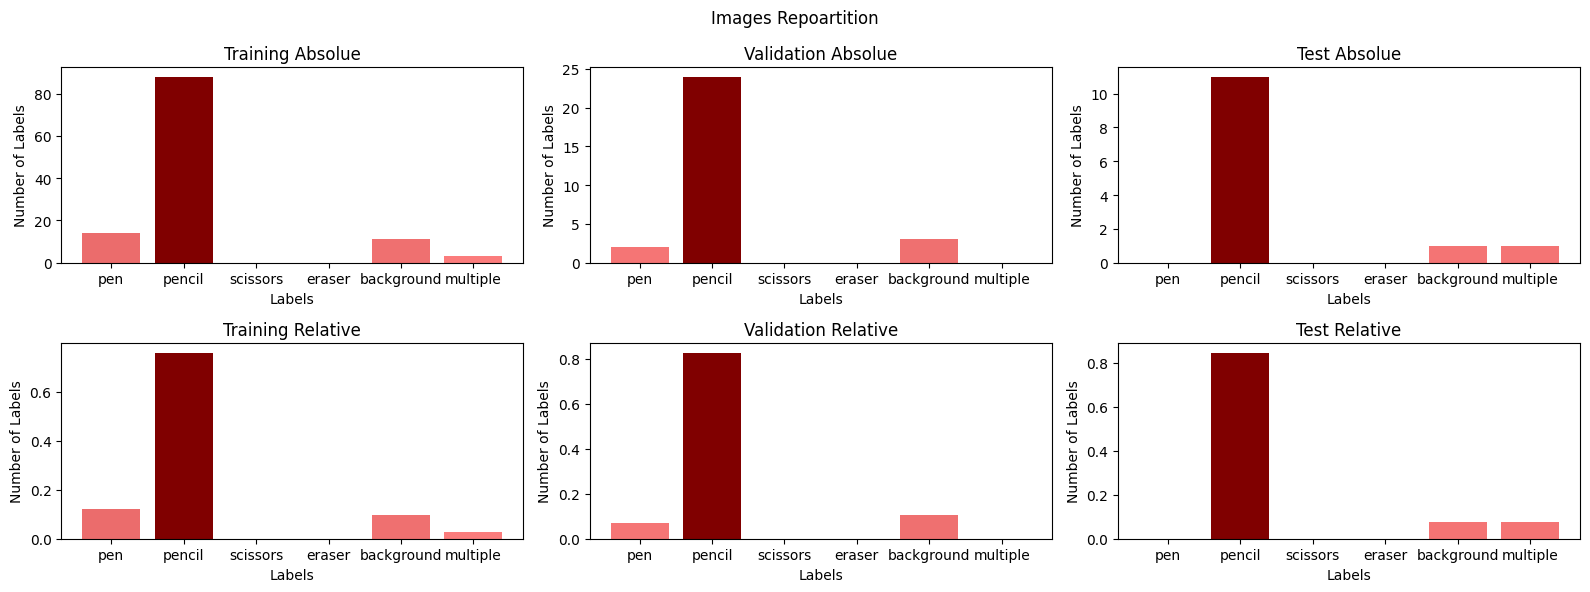

In [23]:
test_num_labels = np.array(list(test_images_repartition.values()))
train_num_labels = np.array(list(train_images_repartition.values()))
valid_num_labels = np.array(list(valid_images_repartition.values()))

fig, axes = plt.subplots(2, 3, figsize=(16, 6))

ax = axes[0][0]
ax.bar(list(train_images_repartition.keys()),train_num_labels,color=color(train_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Absolue')


ax = axes[0][1]
ax.bar(list(valid_images_repartition.keys()),valid_num_labels,color=color(valid_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Absolue')

ax = axes[0][2]
ax.bar(list(test_images_repartition.keys()),test_num_labels,color=color(test_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Absolue')

ax = axes[1][0]
ax.bar(list(train_images_repartition.keys()),train_num_labels/np.sum(train_num_labels),color=color(train_num_labels/np.sum(train_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Relative')

ax = axes[1][1]
ax.bar(list(valid_images_repartition.keys()),valid_num_labels/np.sum(valid_num_labels),color=color(valid_num_labels/np.sum(valid_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Relative')

ax = axes[1][2]
ax.bar(list(test_images_repartition.keys()),test_num_labels/np.sum(test_num_labels),color=color(test_num_labels/np.sum(test_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Relative')

fig.suptitle('Images Repoartition')
fig.tight_layout()
plt.show()

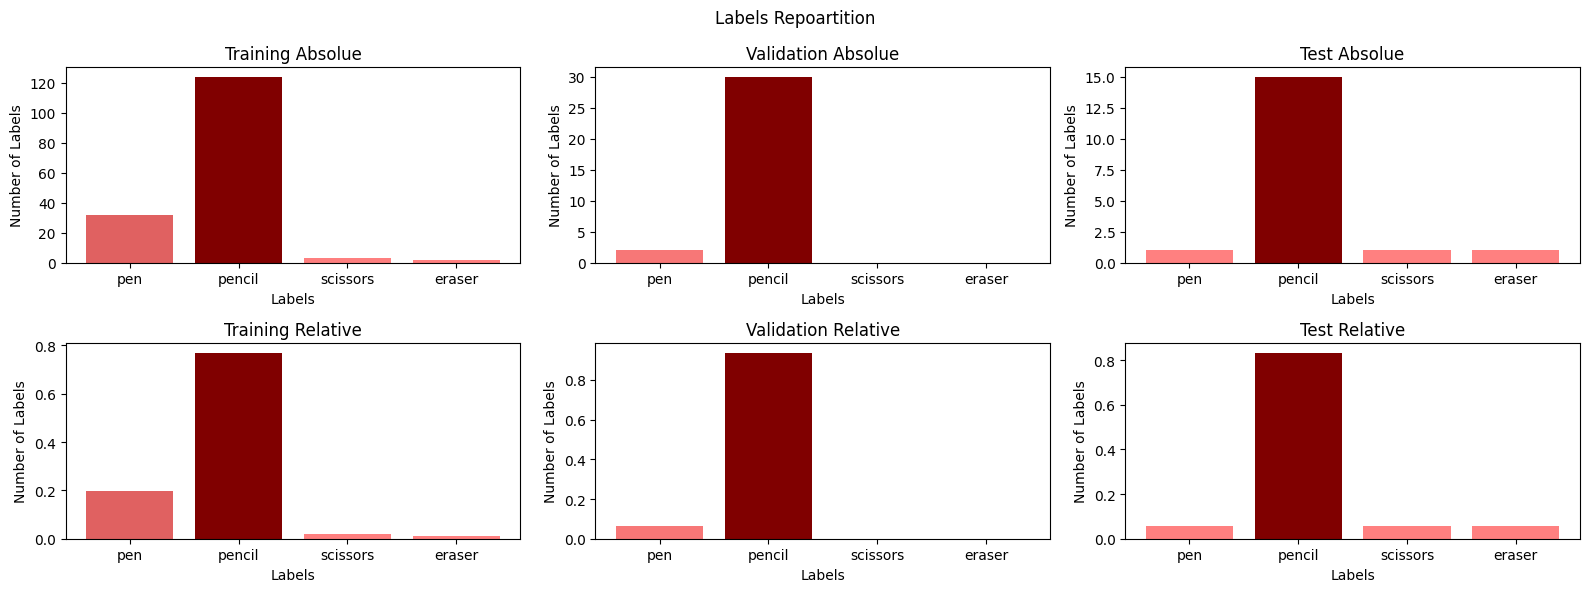

In [24]:
test_num_labels = np.array(list(test_labels_repartition.values()))
train_num_labels = np.array(list(train_labels_repartition.values()))
valid_num_labels = np.array(list(valid_labels_repartition.values()))

fig, axes = plt.subplots(2, 3, figsize=(16, 6))

ax = axes[0][0]
ax.bar(list(train_labels_repartition.keys()),train_num_labels,color=color(train_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Absolue')


ax = axes[0][1]
ax.bar(list(valid_labels_repartition.keys()),valid_num_labels,color=color(valid_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Absolue')

ax = axes[0][2]
ax.bar(list(test_labels_repartition.keys()),test_num_labels,color=color(test_num_labels))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Absolue')

ax = axes[1][0]
ax.bar(list(train_labels_repartition.keys()),train_num_labels/np.sum(train_num_labels),color=color(train_num_labels/np.sum(train_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Training Relative')

ax = axes[1][1]
ax.bar(list(valid_labels_repartition.keys()),valid_num_labels/np.sum(valid_num_labels),color=color(valid_num_labels/np.sum(valid_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Validation Relative')

ax = axes[1][2]
ax.bar(list(test_labels_repartition.keys()),test_num_labels/np.sum(test_num_labels),color=color(test_num_labels/np.sum(test_num_labels)))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Labels')
ax.set_title('Test Relative')

fig.suptitle('Labels Repoartition')
fig.tight_layout()
plt.show()

## Images Aumgentation

Create yaml file to increase number of images

In [24]:
path = os.path.join(paths['YOLO5_PATH'],'data','hyps','hyp.scratch-med.yaml')
with open(path, 'r') as file:
    hyp_yaml = yaml.safe_load(file)

In [25]:
with open(files['IMG_AUGMENTATION_YAML'], 'w') as file:
    documents = yaml.dump(hyp_yaml, file)

## Train Model

In [18]:
img_size = 640
batch = 5
epochs = 2
workers = 2
yolo_model_type = 'n' #n or s # if start from scratch
model_number = None # model from where to start, None if start from scratch

In [14]:
if model_number is not None:
    model_path = os.path.join(paths['MODELS_PATH'],'train',f'model_{model_number}')
    weights_path = os.path.join(model_path,'weights','best.pt')
else : 
    weights_path = None
    
if yolo_model_type == 'n':
    cfg_path = files['YOLO5N_YAML']
elif yolo_model_type == 's':
    cfg_path = files['YOLO5S_YAML']

In [15]:
try:
    model_number = max(int(name[-1]) for name in os.listdir(os.path.join(paths['MODELS_PATH'],'train')))+1
except Exception:
    model_number = 0
new_model_path = os.path.join(paths['MODELS_PATH'],'train',f'model_{model_number}')

In [16]:
print(new_model_path)
print(weights_path)
print(cfg_path)

/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models/train/model_1
None
/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/yolov5/models/yolov5n.yaml


In [19]:
command = f'python {files["TRAIN_PY"]} --img {img_size} --batch {batch} --epochs {epochs} --data {files["DATASET_YAML"]} --cfg {cfg_path} --workers {workers} --project {paths["MODELS_PATH"]} --name {new_model_path} --hyp {files["IMG_AUGMENTATION_YAML"]}'
if weights_path : 
    command = f'{command} --weights {weights_path}'
print(command)

python /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/yolov5/train.py --img 640 --batch 5 --epochs 2 --data /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/dataset.yaml --cfg /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/yolov5/models/yolov5n.yaml --workers 2 --project /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models --name /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models/train/model_1 --hyp /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/hyp_img_augm.yaml


## Evalutate Model

In [34]:
model_number = 3

In [35]:
test_model_path = os.path.join(paths['MODELS_PATH'],'test',f'model_{model_number}')
train_model_path = os.path.join(paths['MODELS_PATH'],'train',f'model_{model_number}')
weigths_path =  os.path.join(paths['MODELS_PATH'],'train',f'model_{model_number}','weights','best.pt')

In [36]:
command = f'python {files["VALIDATE_PY"]} --weights {weigths_path} --data {files["DATASET_YAML"]} --img {img_size} --project {paths["MODELS_PATH"]} --name {test_model_path}'
!{command}

val: data=/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/dataset.yaml, weights=['/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models/train/model_2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models, name=/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/data/models/test/model_2, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-53-g65071da Python-3.8.10 torch-1.12.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/det
                 Class     Images  Instances          P      

In [80]:
!tensorboard --logdir {paths['MODELS_PATH']}

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Load Model

In [37]:
model_name = 'model_2'

In [82]:
model_path = os.path.join(paths['MODELS_PATH'],'train',model_name)
weigths_path = os.path.join(model_path,'weights','best.pt')

In [83]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weigths_path, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/alessandrini/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-12-31 Python-3.8.10 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


## Real Time Detection

In [85]:
# set model confidence limit
model.conf = 0.2
dimension = (img_size,img_size)

In [86]:
cap = cv2.VideoCapture(0)

prev_frame_time = 0
new_frame_time = 0

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.resize(frame,dimension)
    # Make detections 
    results = model(frame)
    results_frame = np.squeeze(results.render())

    new_frame_time = time.time()
    fps = round(1/(new_frame_time-prev_frame_time),2)
    prev_frame_time = new_frame_time
    cv2.putText(results_frame, f'FPS : {fps}Hz', (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 255, 0), 1, cv2.LINE_AA)
    cv2.imshow('YOLO', results_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Image Recognition

In [87]:
# set model confidence limit
model.conf = 0.2
dimension = (img_size,img_size)
n = 2

In [ ]:
images = [name for name in os.listdir(os.path.join(paths['TEST_PATH'],'images')) if name.endswith('.jpg')]

for image in images[:]:
    results = model(os.path.join(paths['TEST_PATH'],'images',image))
    results.print()
    %matplotlib inline 
    plt.imshow(np.squeeze(results.render()))
    plt.show()

## Export

We export to the ONNX format so we can use it with cv2.dnn module instead of pytorch.

In [11]:
model_number = 4
weigths_path =  os.path.join(paths['MODELS_PATH'],'train',f'model_{model_number}','weights','best.pt')

In [12]:
!python {files['EXPORT_PY']} --weights {weigths_path} --include onnx --imgsz {img_size} {img_size}

Traceback (most recent call last):
  File "/home/alessandrini/Documents/Robot/Eden_Robotics/Python/vision/detection/yolo/yolov5/export.py", line 60, in <module>
    import torch
  File "/home/alessandrini/.local/lib/python3.8/site-packages/torch/__init__.py", line 753, in <module>
    from .serialization import save, load
  File "/home/alessandrini/.local/lib/python3.8/site-packages/torch/serialization.py", line 18, in <module>
    from typing_extensions import TypeAlias
ImportError: cannot import name 'TypeAlias' from 'typing_extensions' (/usr/lib/python3/dist-packages/typing_extensions.py)


## Detection With OpenCV DNN

In [91]:
INPUT_WIDTH = img_size
INPUT_HEIGHT = img_size
SCORE_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4
CONFIDENCE_THRESHOLD = 0.4

In [92]:
def build_model(model_path):
    net = cv2.dnn.readNet(model_path)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    return net

In [93]:
def detect(image, net):
    blob = cv2.dnn.blobFromImage(image, 1/255.0, size = (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
    net.setInput(blob)
    return net.forward()

In [94]:
def wrap_detection(input_image, output_data):
    class_ids = []
    confidences = []
    boxes = []

    rows = output_data.shape[0]

    image_width, image_height, _ = input_image.shape

    x_factor = image_width / INPUT_WIDTH
    y_factor =  image_height / INPUT_HEIGHT

    for r in range(rows):
        row = output_data[r]
        confidence = row[4]
        if confidence >= 0.4:

            classes_scores = row[5:]
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores)
            class_id = max_indx[1]
            if (classes_scores[class_id] > .25):

                confidences.append(confidence)

                class_ids.append(class_id)

                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])
                boxes.append(box)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45) 

    result_class_ids = []
    result_confidences = []
    result_boxes = []

    for i in indexes:
        result_confidences.append(confidences[i])
        result_class_ids.append(class_ids[i])
        result_boxes.append(boxes[i])

    return result_class_ids, result_confidences, result_boxes

In [95]:
def format_yolov5(frame):
    row, col, _ = frame.shape
    _max = max(col, row)
    result = np.zeros((_max, _max, 3), np.uint8)
    result[0:row, 0:col] = frame
    return result

In [96]:
model_name = 'model_1'
model_path = os.path.join(paths['MODELS_PATH'],'train',model_name,'weights','best.onnx')

In [112]:
net = cv2.dnn.readNet(model_path)

[ERROR:0@2465.576] global onnx_importer.cpp:1051 handleNode DNN/ONNX: ERROR during processing node with 2 inputs and 1 outputs: [Add]:(onnx_node!/model.24/Add) from domain='ai.onnx'


error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1073: error: (-2:Unspecified error) in function 'handleNode'
> Node [Add@ai.onnx]:(onnx_node!/model.24/Add) parse error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/layers/nary_eltwise_layers.cpp:139: error: (-215:Assertion failed) shape[i] == 1 || outShape[i] == 1 in function 'findCommonShape'
> 

In [71]:
cap = cv2.VideoCapture(0)
net = build_model(model_path)

prev_frame_time = 0
new_frame_time = 0

colors = (random.randint(0, 255), random.randint(0,255), random.randint(0, 255))

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.resize(frame,(img_size,img_size))
    # Make detections 
    inputImage = format_yolov5(frame)
    outs = detect(inputImage, net)
    class_ids, confidences, boxes = wrap_detection(inputImage, outs[0])


    for (classid, confidence, box) in zip(class_ids, confidences, boxes):
         color = colors[int(classid) % len(colors)]
         cv2.rectangle(frame, box, color, 2)
         cv2.rectangle(frame, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
         cv2.putText(frame, labels[classid], (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

    new_frame_time = time.time()
    fps = round(1/(new_frame_time-prev_frame_time),2)
    prev_frame_time = new_frame_time
    cv2.putText(frame, f'FPS : {fps}Hz', (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 255, 0), 1, cv2.LINE_AA)
    cv2.imshow('YOLO', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()